In [ ]:
import os
sep_local = os.path.sep
sep_local

In [1]:
%env TF_KERAS = 1

'/'

In [2]:
import sys
sys.path.append('..' + sep_local + '..' + sep_local + '..') # For Windows import

In [ ]:
import os
os.chdir('..' + sep_local + '..' + sep_local + '..') # For Linux import

In [5]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  GeForce GTX 950M, compute capability 5.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Compute dtype: float16
Variable dtype: float32


In [6]:
import tensorflow as tf
tf.__version__

In [9]:
dataset_name = 'dsprites'
import tensorflow_datasets as tfds

info = tfds.builder(dataset_name).info

print(info)

tfds.core.DatasetInfo(
    name='dsprites',
    version=0.1.0,
    description='dSprites is a dataset of 2D shapes procedurally generated from 6 ground truth
independent latent factors. These factors are *color*, *shape*, *scale*,
*rotation*, *x* and *y* positions of a sprite.

All possible combinations of these latents are present exactly once,
generating N = 737280 total images.

### Latent factor values

*   Color: white
*   Shape: square, ellipse, heart
*   Scale: 6 values linearly spaced in [0.5, 1]
*   Orientation: 40 values in [0, 2 pi]
*   Position X: 32 values in [0, 1]
*   Position Y: 32 values in [0, 1]

We varied one latent at a time (starting from Position Y, then Position X, etc),
and sequentially stored the images in fixed order.
Hence the order along the first dimension is fixed and allows you to map back to
the value of the latents corresponding to that image.

We chose the latents values deliberately to have the smallest step changes
while ensuring that all pixel outp

In [10]:
intermediate_dim = 20
inputs_shape=(64, 64, 1) # image shape
batch_size = 100
latent_dim = 50

In [11]:
TRAIN_BUF = 600
TEST_BUF = 100


In [12]:
import tensorflow_datasets as tfds
# Construct a tf.data.Dataset
train_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TRAIN_BUF).batch(batch_size)
try:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TEST).shuffle(TEST_BUF).batch(batch_size)
except:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TEST_BUF).batch(batch_size)


In [13]:
_instance_scale=1.0
for data in train_ds:
    _instance_scale = float(data['image'][0].numpy().max())
    break

In [14]:
enc_lays = [
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latent_dim)
]

dec_lays = [
    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    
    # No activation
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
]

In [16]:
import os
model_name = dataset_name + 'Dense' +'AE'
#recoding_dir='..'+sep_local+'..'+sep_local+'..'+sep_local+'recording'+sep_local + model_name
os.getcwd()
recoding_dir=os.getcwd()+ sep_local  +'recording'+sep_local + model_name

In [17]:
from os.path import abspath
absolute = abspath(recoding_dir)
print("Recording_dir",absolute)
print("Current working dir",os.getcwd())


In [18]:
from training.traditional.autoencoders.autoencoder import autoencoder as AE

In [22]:
variables_params = \
[
    {
        'name': 'inference', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latent_dim,
        'layers': enc_lays
    }
    ,
    
        {
        'name': 'generative', 
        'inputs_shape':latent_dim,
        'outputs_shape':inputs_shape,
        'layers':dec_lays
    }
]

In [23]:
from utils.data_and_files.file_utils import create_if_not_exist
_restore = os.path.join(recoding_dir, 'var_save_dir')
create_if_not_exist(_restore)
absolute = abspath(_restore)
print("Restore_dir",absolute)

In [24]:
ae = AE( 
    name=model_name,
    inputs_shape=inputs_shape,
    outputs_shape=inputs_shape,
    latent_dim=latent_dim,
    batch_size=batch_size,
    variables_params=variables_params, 
    filepath=None #to restore trained model, set filepath=_restore
    )

'../../recoding/dspritesAE/var_save_dir'

In [25]:
#ae.compile(metrics=None)
ae.compile()

  WARNING  | None
  WARNING  | None


Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                720050    
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                20

In [26]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
from training.callbacks.progress_bar import NotebookPrograssBar
from training.callbacks.sample_generation import SampleGeneration
from training.callbacks.save_model import ModelSaver

In [3]:
progbar = NotebookPrograssBar(leave_outer=False)

In [4]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=1e-12, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

  INFO     | ==================================================================
  DEBUG    | TRAIN
    Epoch: 0
    bce: -603605.75
    Total: -24.23484230041504
    Elapsed: 1256.778975
  INFO     | ==================================================================
  INFO     | ==================================================================
  DEBUG    | TEST
    Epoch: 0
    bce: -186670.796875
    Total: -20.72909164428711
    Elapsed: 232.195890
  INFO     | ==================================================================


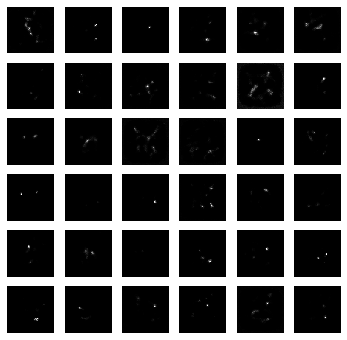

  CRITICAL | Saving Status in Epoch 0
Epochs Progress, Training Iterations 7372:   1%|          | 1/100 [1:07:12<110:53:07, 4032.20s/it]  INFO     | Training ... 


Epochs Progress, Training Iterations 5073:   1%|          | 1/100 [1:21:33<110:53:07, 4032.20s/it]

In [ ]:
ms = ModelSaver(filepath=_restore,save_freq=5)

In [ ]:
csv_dir = os.path.join(recoding_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, model_name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
absolute = abspath(csv_dir)
print("Csv_dir",absolute)

In [ ]:
image_gen_dir = os.path.join(recoding_dir, 'image_gen_dir')
create_if_not_exist(image_gen_dir)
absolute = abspath(image_gen_dir)
print("Image_gen_dir",absolute)

In [ ]:
sg = SampleGeneration(latent_shape=6, filepath=image_gen_dir, gen_freq=5, save_img=True, gray_plot=True)

In [ ]:
#DATA_DOWN_PATH = '..'+sep_local+'..'+sep_local+'..'+sep_local+'data'
DATA_DOWN_PATH = os.getcwd() + sep_local+'data'
Script_dir = os.getcwd() + sep_local+'data'+sep_local+'download_gt_data.sh'
# Script call to download "dsprites_full" dataset_name 
!/bin/bash $Script_dir -f $DATA_DOWN_PATH -d $dataset_name

In [ ]:
from data.gt_load.datasets import load
DATA_PATH = DATA_DOWN_PATH +sep_local+'.gt_datasets'
absolute = abspath(DATA_PATH)
print("DATA_PATH",absolute)

In [ ]:
eval_dataset = load(dataset_name='dsprites_full', dataset_path=DATA_PATH)

In [ ]:
gts_csv = os.path.join(recoding_dir, 'csv_dir', 'gts_metrics')
gtu_csv = os.path.join(recoding_dir, 'csv_dir', 'gtu_metrics')

In [ ]:
import numpy as np

In [ ]:
from training.callbacks.disentangle_supervied import DisentanglementSuperviedMetrics
from training.callbacks.disentangle_unsupervied import DisentanglementUnsuperviedMetrics

In [ ]:
gts_mertics = DisentanglementSuperviedMetrics(            
    ground_truth_data=eval_dataset,
    representation_fn=lambda x: ae.encode(inputs={'x_mean': x, 'x_logvar': x})['x_latent'],
    random_state=np.random.RandomState(0),
    file_Name=gts_csv,
    num_train=1000,
    num_test=200,
    batch_size=batch_size,
    continuous_factors=False,
    gt_freq=2
)
gtu_mertics = DisentanglementUnsuperviedMetrics(            
    ground_truth_data=eval_dataset,
    representation_fn=lambda x: ae.encode(inputs={'x_mean': x, 'x_logvar': x})['x_latent'],
    random_state=np.random.RandomState(0),
    file_Name=gtu_csv,
    num_train=1000,
    num_test=200,
    batch_size=batch_size,
    gt_freq=2
)

In [ ]:
ae.fit(
    x=train_ds,
    steps_per_epoch=50,
    epochs=100, 
    verbose=0,
    callbacks=[progbar, es, ms, csv_log, sg, gts_mertics, gtu_mertics],
    workers=-1,
    use_multiprocessing=True
)
